In [1]:
from pathlib import Path
from joblib import Memory
import h5py
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch, find_peaks, ricker, cwt
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

In [2]:
DATA_DIR = Path.cwd() / 'data/' # EMG signals
CACHE_DIR = Path.cwd() / 'cache/' # cache previously done computations (via joblib)

memory = Memory(CACHE_DIR)

## Pre-Processing Functions

The following functions pre-process the surface EMG signals
via digital filters. One filter is a bandpass filter (from 20 Hz to 500 Hz) and the other is a notch filter
at 50 Hz. 

A sampling rate of 2048 Hz is used. 

The code seems to imply a sampling rate of 4 kHz however?

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/ nyq, highcut/ nyq], btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def notch(notch_freq, samp_freq, quality_factor=30):
    b, a = iirnotch(notch_freq, quality_factor, samp_freq)
    return b, a

def notch_filter(data, notch_fs, fs, q=30):
    b, a = notch(notch_fs, fs, q)
    y = filtfilt(b, a, data)
    return y

@memory.cache
def filt_GRID(data, lowcut=20, highcut=500, fs=4000, order=3, notch_fs = 50, notch_q = 30):
    filt_out = np.zeros_like(data)
    for i in range(data.shape[0]):
        filt_out[i,:] = notch_filter(butter_bandpass_filter(data[i,:], lowcut, highcut, fs, order=order), notch_fs, fs, notch_q)
    return filt_out


In [376]:
def loadmat(filename):
    file = h5py.File(filename, 'r')
    return np.asarray(file['grid_crds']), np.asarray(file['out_mat'])

if1_grid_crds, if1_out_mat = loadmat(DATA_DIR / r'increasing-force-1.mat')
if2_grid_crds, if2_out_mat = loadmat(DATA_DIR / r'increasing-force-2.mat')
sf1_grid_crds, sf1_out_mat = loadmat(DATA_DIR / r'steady-force-1.mat')

emg = if2_out_mat

print(emg.shape)

(72360, 64)


The surface EMG signals, as collected at all the electrodes, are held in the ``emg`` variable.
Each column is a separate electrode, and the rows denote how the signal at that electrode evolves over time.

There are a total of 64 electrodes, arranged like the following:

<div>
<img src="electrodes.png" width="500"/>
</div>


In [377]:
filtered_if1_out_mat = filt_GRID(emg.T).T

In [378]:
def plot_emg(emg, time_bounds=None, channels=[], figsize=None):

    if not channels:
        num_rows = emg.shape[1]
        channels = range(1, emg.shape[1]+1)
    else:
        num_rows = len(channels)

    if figsize is None:
        print(num_rows)
        figsize = [10, (15 * num_rows) // 8]
        print(figsize)

    #if time_bounds is None:
    #    time_bounds = (10000, 10000+1500)

    left, right = time_bounds
    assert 0 <= left <= right

    fig, ax = plt.subplots(nrows=num_rows, figsize=figsize)
    #fig, ax = plt.subplots(nrows=1)

    for i, idx in enumerate(channels):
        curr_ax = ax[i] if len(channels) != 1 else ax # handles singleton case
        curr_ax.plot(emg[:, idx-1])
        curr_ax.set_xlim(left=left, right=right)
        curr_ax.set_ylabel(f"Electrode {idx}")
        #ax.plot(emg[:, i])
        #ax.set_xlim(left=left, right=right)
        #ax.set_ylabel(f"Electrode {i*step_size}")
    
    
    return fig, ax

[8, 16, 24, 32, 40, 48, 56, 64, 7, 15, 23, 31, 39, 47, 55, 63, 6, 14, 22, 30, 38, 46, 54, 62, 5, 13, 21, 29, 37, 45, 53, 61, 4, 12, 20, 28, 36, 44, 52, 60, 3, 11, 19, 27, 35, 43, 51, 59, 2, 10, 18, 26, 34, 42, 50, 58, 1, 9, 17, 25, 33, 41, 49, 57]
64
[10, 120]


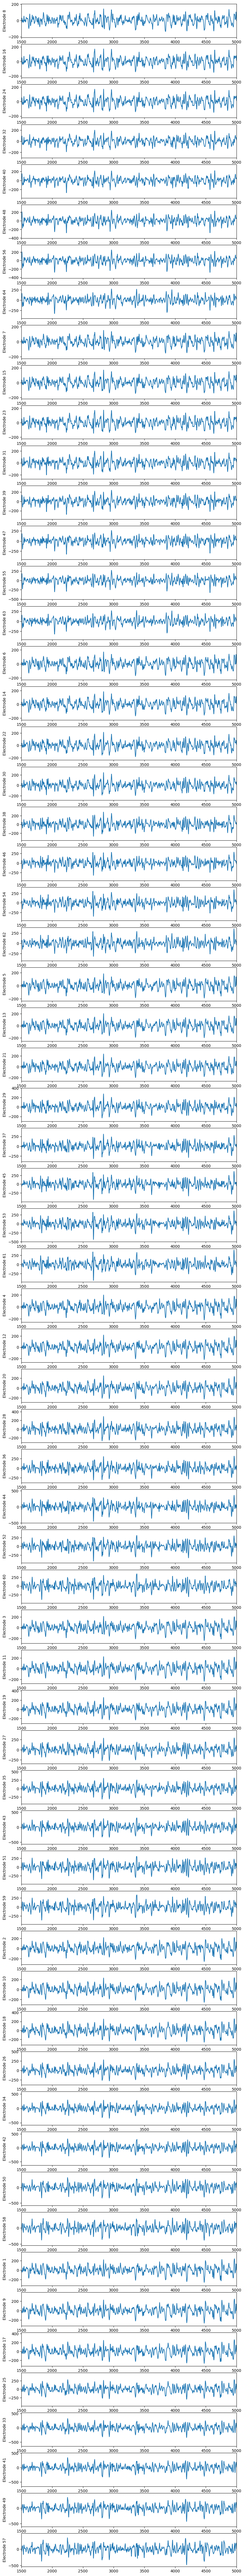

In [379]:
#%matplotlib ipympl
channels = list(np.flipud(np.arange(64).reshape((8,8)).T + 1).ravel())
print(channels)
fig, ax = plot_emg(filtered_if1_out_mat, channels=channels, time_bounds=(1500, 5000))
plt.show()


## Firing Time Estimation

Our process for performing firing time estimation will mirror that of two-stage object detection. 

1. *Region Proposals.* Typical MUAP pulses have a duration of around 5-15 ms (Electromyography and Neuromuscular Disorders, pages 235-248, 2013, Preston, David C.). Specifically, we will break up the signals into windows which are 10 ms long, with some overlap between them. We will then run a very simple detector on these windows to classify them as *active* (has at least one MUAP in it) or *inactive*. Since the sampling rate is 2048 Hz, then this corresponds to 10 to 30 sample windows, approximately.

For now, the detector is based on a combination of the Ricker wavelet (which has a shape that resembles MUAP pulses) and clustering. Specifically, we will first use the Ricker wavelet to perform a matched filtering sort of operation at different scales (so as
to pick up on MUAPs of varying lengths). In a sense, this will yield a feature vector for every single window. We will then measure the sparsity and energy (l1 and l2 norm) for each feature vector. We ideally want the energy for each feature vector to be high;
furthermore, we want the inverse of the l1 norm (the higher the inverse is, the more sparse the data is) to be high as well. We thus will use the following score to assess whether a window contains an MUAP (or several):

$$
\begin{align*} 
\lambda_1 &= \frac{a}{\lVert x \rVert_1 + \epsilon} \\
\lambda_2 &= b \lVert x \rVert_2 \\
\text{Activity} &= \exp(\lambda_1 \lambda_2 - k (\lambda_1 + \lambda_2)^p)
\end{align*}
$$

$k$ is some empirically determined constant -- for now, we set it to $1$. $\epsilon$ is some small value added to prevent zero divison errors.
$p$ is also empirically determined, and we set it to $1$ as well. The lower this value, the more sensitive the detector (higher recall) -- and the higher it is, the less sensitive it is.
$a$ and $b$ are empirically determined, and control how important sparsity or energy is, respectively.

We then perform clustering on these scores, assuming two clusters, to identify them as *active* or *inactive*. The cluster that has the fewest elements is assumed to be the cluster corresponding to *active* -- this assumes that MUAP firings do not make up
the majority of the signal.

The Ricker wavelet has a width parameter $a$ which controls the length of the main pulse. Generally, we notice that the pulse duration ends up being around $5a$ -- thus, the range of wavelet widths we will iterate through, so as to analyze 10 to 30 sample windows,
will be $a=2..6$. To give a little more room to work with, we will go from 2 to 10.

2. *Dictionary Based Representation.* We will use a dictionary to represent each of the windows as the sum of one or more MUAP pulses. The number of dictionary elements is the number of assumed sources.

In [380]:
# filtered_IC = butter_bandpass_filter(IC.T, lowcut=50, highcut=150, fs=4000).T

# fig, ax = plt.subplots(nrows=filtered_IC.shape[1]//8, figsize=[10, 10])
# for i in range(0, filtered_IC.shape[1]//8):
#     ax[i].plot(filtered_IC[:, i])
#     ax[i].set_xlim(left=10000, right=10000+1500)
# plt.show()

In [381]:
from sklearn.cluster import KMeans

start, stop = 0, filtered_if1_out_mat.shape[0] # start and stop time in samples
electrode = 32 # lower left electrode, closest on arm, in previously shown diagram

wavelet_convolved = []
WIDTHS = np.arange(2, 10, 1) # roughly estimated based on total duration of Ricker wavelet, wavelet width, and durations of MUAP pulses

for i in range(emg.shape[1]):
    wavelet_convolved.append(cwt(filtered_if1_out_mat[:, i], ricker, WIDTHS))

wavelet_convolved = np.asarray(wavelet_convolved)
wavelet_convolved = np.moveaxis(wavelet_convolved, [0, 1, 2], [0, 2, 1])
print(wavelet_convolved.shape) # shape is electrode number, time, wavelet width\

(64, 72360, 8)


(64, 72360)


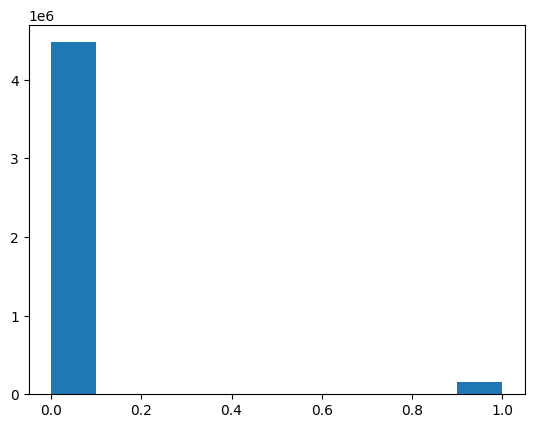

In [382]:
a = 1 # sparsity weight
b = 1 # energy weight
lambda1 = a / (1e-24 + np.linalg.norm(wavelet_convolved, axis=-1, ord=1))
lambda2 = b * np.linalg.norm(wavelet_convolved, axis=-1, ord=-np.inf)

k = 2.5
p = 1

#plt.figure()
#plt.plot(filtered_if1_out_mat[start:stop,electrode])

activity = lambda1 * lambda2 - k*(lambda1 + lambda2)**p
activity = np.exp(activity)
#activity = lambda1*lambda2/(lambda1+lambda2)
activity.shape

#plt.figure()
#plt.plot(activity[electrode,start:stop])

s = activity[:, start:stop].shape
assignments = KMeans(n_clusters=2, n_init="auto").fit_predict(activity[:, start:stop].reshape(1,-1).T)
#assignments = KMeans(n_clusters=2, n_init="auto").fit_predict(wavelet_convolved[0,100:-100,:])

plt.figure()
plt.hist(assignments)


assignments = assignments.reshape(s)
print(assignments.shape)

#assignments = assignments[electrode,:] # focus on particular electrode

unique, counts = np.unique(assignments, return_counts=True)

1


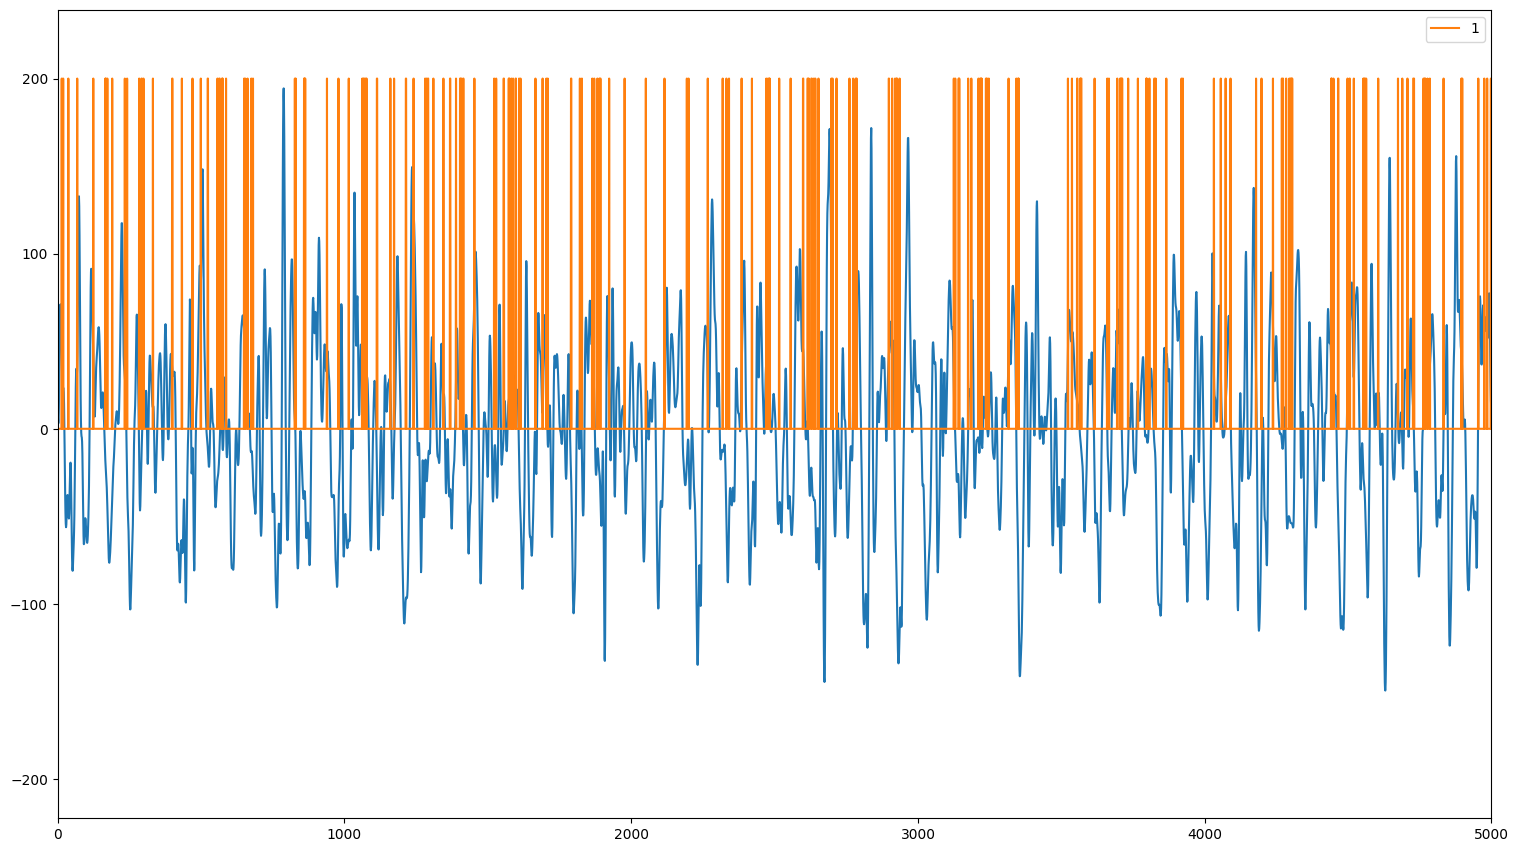

In [383]:
activity_cluster_id = np.argmin(counts)

print(activity_cluster_id)

#plt.figure()
#plt.plot(assignments == activity_cluster_id)
#plt.xlim(0,1500)

electrode = 23

plt.figure()
plt.plot(filtered_if1_out_mat[start:stop,electrode])
plt.plot(200*(assignments[electrode,:] == activity_cluster_id), label=p)
plt.xlim(0,5000)

fig = plt.gcf() 
fig.set_size_inches(18.5, 10.5)

plt.legend()
plt.show()

In [384]:
(assignments[:, start:stop] == activity_cluster_id).sum() / (assignments[:, start:stop]).size

0.03400229754007739

We want the above score (the percentage of the signal we need to analyze, to be just right -- too low, and this likely means we have low recall, but too high and the amount of computation needed goes up for subsequent stages.

In [385]:
filtered_emg = filtered_if1_out_mat.T # stack signals row-wise
filtered_emg = filtered_emg.ravel() # make it one big 1D signal

idxs, = np.where(assignments.ravel() == activity_cluster_id)
idxs = np.expand_dims(idxs, axis=0)

print(idxs)

window = 64
half_window = window // 2
idxs = idxs[idxs + half_window < filtered_emg.shape[0]]
idxs = idxs + np.expand_dims(np.arange(-half_window, half_window + 1), axis=1)

#idxs = idxs.T.ravel()
idxs = idxs.T
#mask = idxs[:,-1] < filtered_emg.shape[0]
#idxs = idxs[mask,:]

[[      4      19      27 ... 4631003 4631005 4631008]]


In [386]:
windows = filtered_emg[idxs]

In [387]:
windows.shape

(157465, 65)

(0.0, 1500.0)

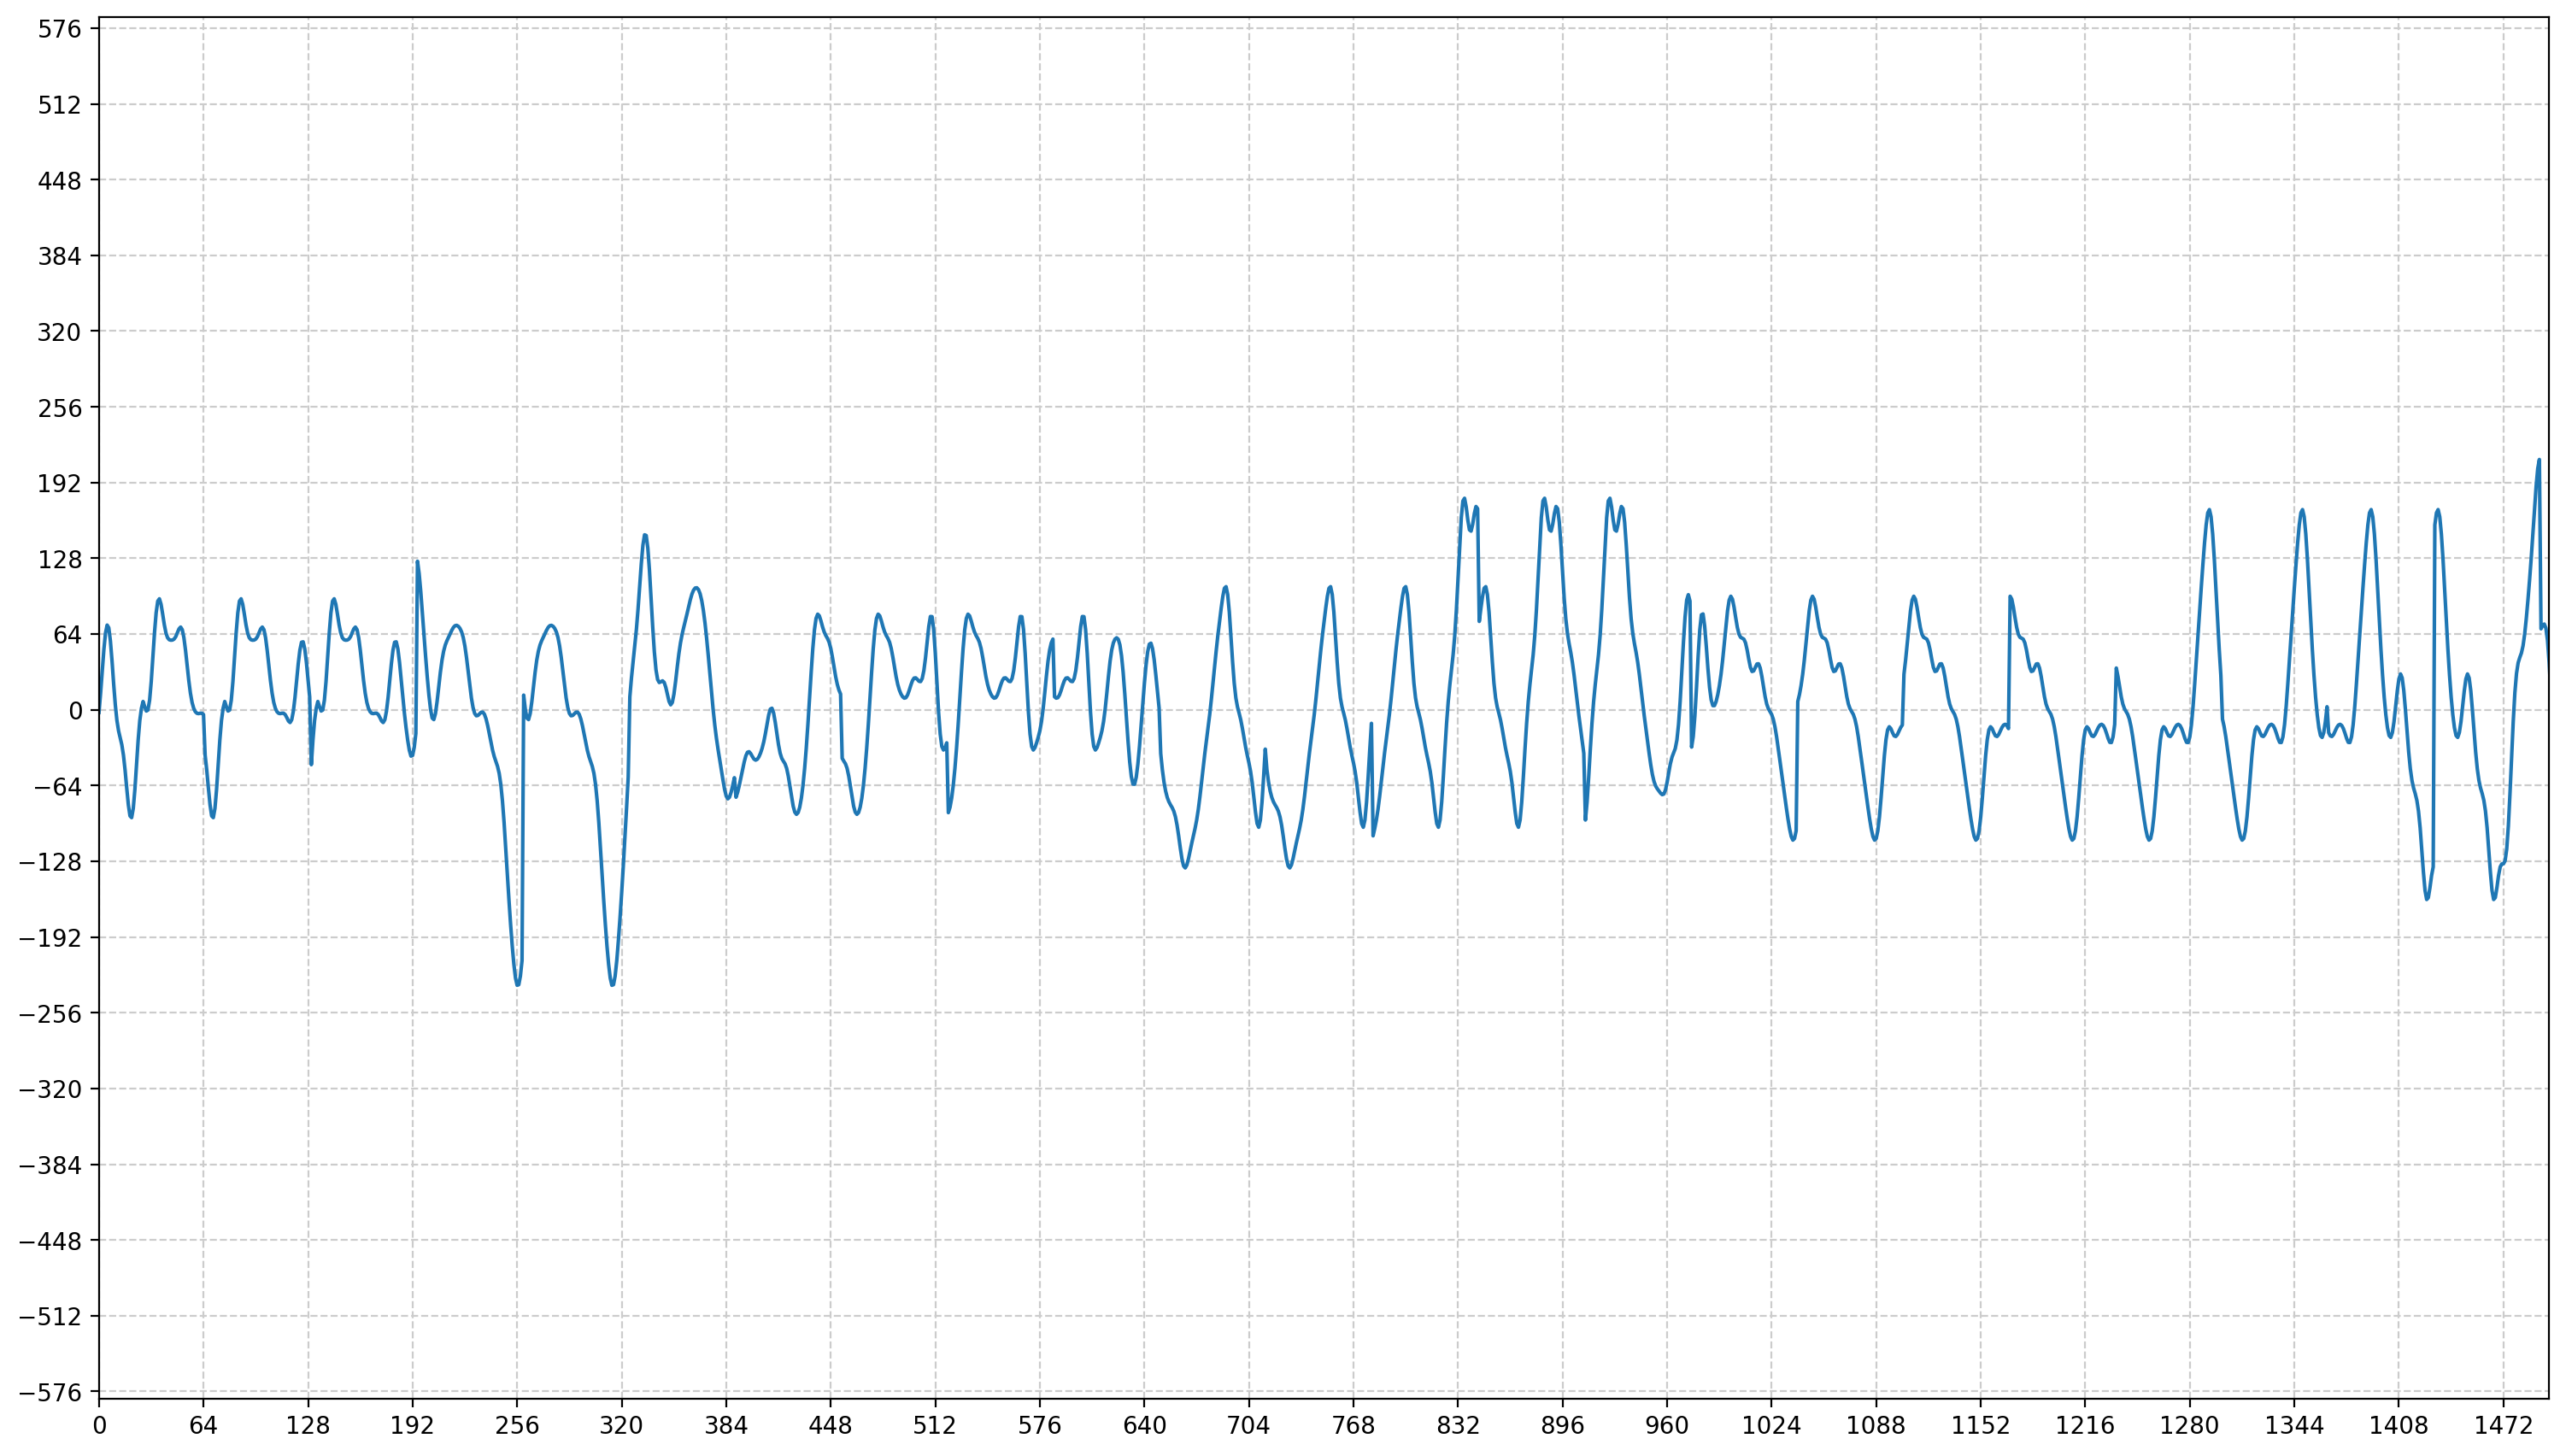

In [388]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
fig.set_dpi(200)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(window))
ax.yaxis.set_major_locator(MultipleLocator(window))

# Change minor ticks to show every 5. (20/4 = 5)
#ax.xaxis.set_minor_locator(AutoMinorLocator(4))
#ax.yaxis.set_minor_locator(AutoMinorLocator(4))

ax.grid(which='major', color='#CCCCCC', linestyle='--')
#ax.grid(which='minor', color='#CCCCCC', linestyle=':')

plt.plot(windows[:,:].ravel())
plt.xlim(0,1500)

The gridlines are spaced so that an entire window is contained between adjacent gridlines. This allows us to get an idea of what an active window of the filtered EMG (has one or more MUAPs present) looks like.

In [389]:
templates = KMeans(n_clusters=10, n_init="auto").fit(windows)

templates.cluster_centers_.shape

(10, 65)

Now, we perform clustering on the identified active windows to determine what canonical MUAP pulses tend to look like. The cluster centers are plotted below.

We will follow this up with a dictionary based approach, which will better account for the superposition of MUAPs in a single window,
but the basic clustering serves as a sanity check of sorts.

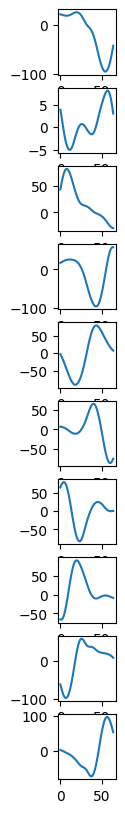

In [390]:
fig, ax = plt.subplots(nrows=len(templates.cluster_centers_))
fig.set_size_inches(0.75,10)


for i in range(len(templates.cluster_centers_)):
    ax[i].plot(templates.cluster_centers_[i,:])


In [399]:
from sklearn.decomposition import MiniBatchDictionaryLearning

#dict_learner = MiniBatchDictionaryLearning(n_components=15, batch_size=3, transform_algorithm='lasso_lars', transform_alpha=0.1)
#dict_learner = MiniBatchDictionaryLearning(n_components=10, batch_size=128, verbose=True, n_jobs=8, transform_algorithm='omp', alpha=50, fit_algorithm='cd')
dict_learner = MiniBatchDictionaryLearning(n_components=20, batch_size=256, verbose=True, alpha=100, transform_algorithm='threshold')

idx = np.arange(len(windows))
np.random.shuffle(idx)
idx = idx[:1024]
X_transformed = dict_learner.fit(windows[idx,:])

dict_learner.components_

[dict_learning]
0 batches processed.
100 batches processed.
200 batches processed.
300 batches processed.
400 batches processed.
500 batches processed.
600 batches processed.
700 batches processed.
800 batches processed.
900 batches processed.


array([[-0.11633735, -0.13040374, -0.14434194, ...,  0.03644526,
         0.02825814,  0.0196507 ],
       [ 0.06554382,  0.06152836,  0.05750901, ...,  0.1796847 ,
         0.16319385,  0.14289412],
       [-0.20852369, -0.22461625, -0.23793726, ..., -0.01818279,
        -0.02193833, -0.02512468],
       ...,
       [-0.19970388, -0.23550122, -0.26421146, ...,  0.01319681,
         0.02690298,  0.04170841],
       [ 0.09206493,  0.10394108,  0.11464412, ...,  0.16050017,
         0.1456153 ,  0.12727361],
       [-0.11312888, -0.12097334, -0.12609969, ...,  0.17392732,
         0.16945735,  0.16125332]])

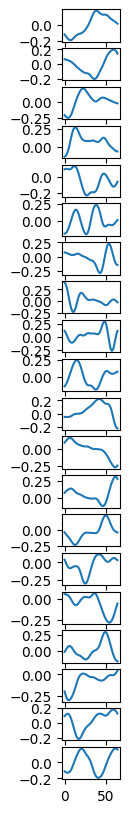

In [400]:
fig, ax = plt.subplots(nrows=len(dict_learner.components_))
fig.set_size_inches(0.75,10)


for i in range(len(dict_learner.components_)):
    ax[i].plot(dict_learner.components_[i,:])

In [393]:
activations = dict_learner.transform(windows)

(array([ 1333.,     0.,     0.,     0.,     0.,  1498.,     0.,     0.,
            0.,     0.,  2002.,     0.,     0.,     0.,     0.,  2385.,
            0.,     0.,     0.,     0.,  3071.,     0.,     0.,     0.,
            0.,  4095.,     0.,     0.,     0.,     0.,  5429.,     0.,
            0.,     0.,  6898.,     0.,     0.,     0.,     0.,     0.,
         8781.,     0.,     0.,     0.,     0., 10890.,     0.,     0.,
            0.,     0., 13099.,     0.,     0.,     0.,     0., 14799.,
            0.,     0.,     0.,     0., 16302.,     0.,     0.,     0.,
            0., 16537.,     0.,     0.,     0., 15657.,     0.,     0.,
            0.,     0.,     0., 13388.,     0.,     0.,     0.,     0.,
        10210.,     0.,     0.,     0.,     0.,  6519.,     0.,     0.,
            0.,     0.,  3308.,     0.,     0.,     0.,  1072.,     0.,
            0.,     0.,     0.,   192.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 

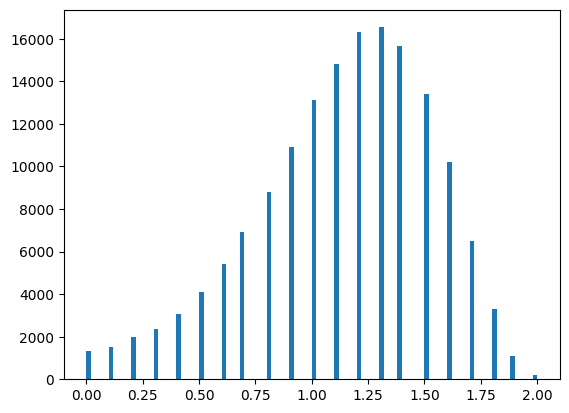

In [394]:
plt.hist((activations != 0).sum(axis=-1) / 10, bins=100)

In [395]:
activations.sum(axis=0).shape

(20,)

<StemContainer object of 3 artists>

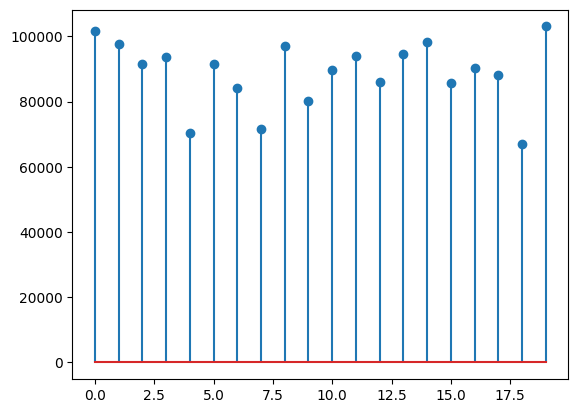

In [396]:
plt.stem((activations != 0).sum(axis=0))

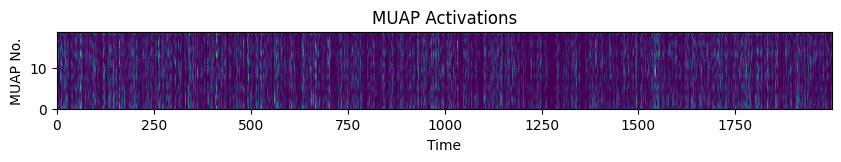

In [397]:
plt.pcolormesh(np.abs(activations[:2000,:].T), shading='gouraud')

plt.title('MUAP Activations')
plt.ylabel('MUAP No.')
plt.xlabel('Time')
plt.gcf().set_size_inches(10,1)
plt.show()

(3840.0, 6400.0)

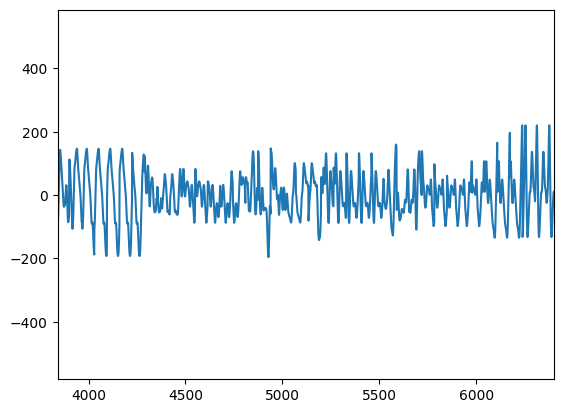

In [398]:
plt.plot(windows[:,:].ravel())
plt.xlim(30*128,50*128)

In [359]:
peaks = np.zeros(shape=(assignments.shape[0], assignments.shape[1], activations.shape[-1]))

In [360]:
peaks.shape

(64, 60160, 20)

In [361]:
window_locs = np.vstack(np.where(assignments)).T

In [362]:
assignments.shape

(64, 60160)

In [363]:
win_idxs = np.where(assignments)
win_idxs = win_idxs[0][:len(activations)], win_idxs[1][:len(activations)]

In [364]:
windows.shape

(250028, 65)

In [365]:
win_idxs[0].shape

(250028,)

In [366]:
activations.shape

(250028, 20)

In [367]:
#peaks[win_idxs[0][:-8], win_idxs[1][:-8], :] = activations[:, :] # TODO: hack for if2 out mat. replace with actual fix
peaks[win_idxs[0], win_idxs[1], :] = activations[:, :]

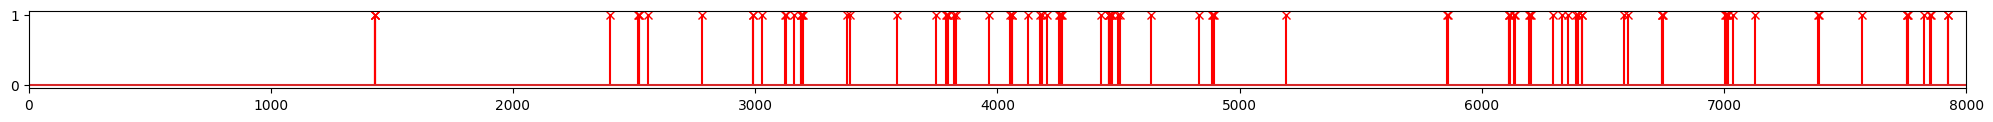

In [373]:
modified = peaks.copy()
modified[modified != 0] = 1
modified[modified != 1] = np.nan
plt.stem(np.abs(modified[0,:,0]), 'red', markerfmt='x')
plt.xlim(0,8000)
plt.gcf().set_size_inches(25,1)


32.33464566929134


Text(0.5, 0, 'Firing Time (ms)')

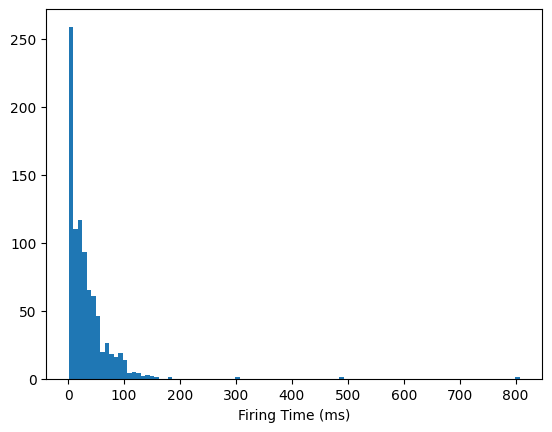

In [402]:
mu = 5 # motor unit
ft, = np.where(peaks[0,:,mu])
isi = ft[1:] - ft[:-1]
isi = isi[isi >= 2]

print(np.mean(isi) / 2)
isi = isi / 2 # sampling period is 0.5 ms
plt.figure()
plt.hist(isi, bins=100)
plt.xlabel("Firing Time (ms)")

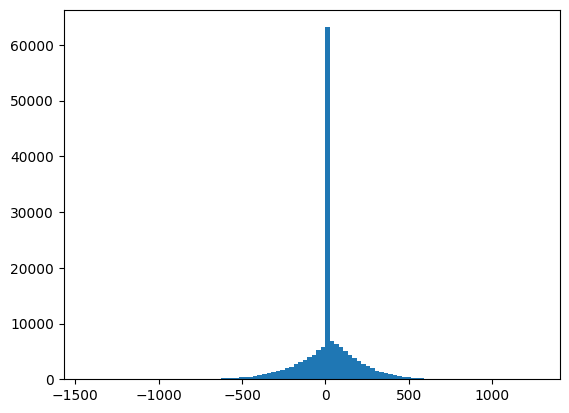

In [403]:
counts, bins, _ = plt.hist(activations[:,0], bins=100)

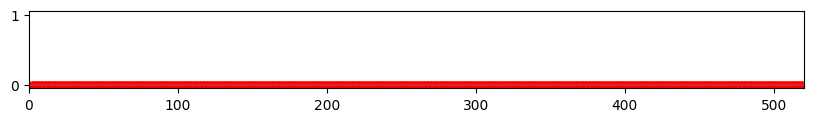

In [415]:
from scipy.ndimage import binary_erosion

mu = 2
m = peaks.copy()
m[m != 0] = 1

#m = binary_erosion(m[0,:,mu], np.ones(1)).astype(float)
#m[m == 0] = np.nan

plt.stem(m[0,:,mu], 'red', markerfmt='x')
plt.xlim(0,520)
plt.gcf().set_size_inches(10,1)

32.04550438596491


ValueError: too many values to unpack (expected 1)

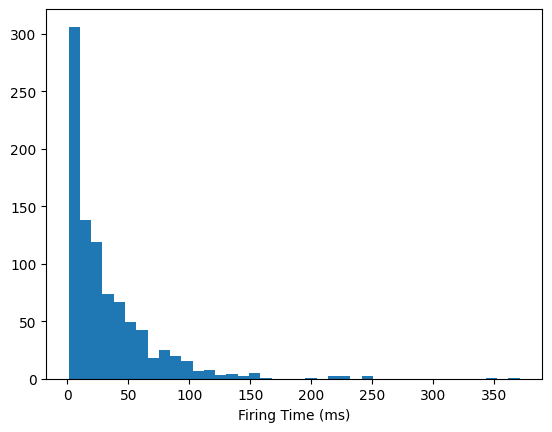

In [408]:
mu = 2 # motor unit
ft, = np.where(peaks[0,:,mu])
isi = ft[1:] - ft[:-1]
isi = isi[isi >= 2]

print(np.mean(isi) / 2)
isi = isi / 2 # sampling period is 0.25 ms
plt.figure()
plt.hist(isi, bins=40)
plt.xlabel("Firing Time (ms)")

m[m == np.nan] = 0
ft, = np.where(m == 0)
isi = ft[1:] - ft[:-1]
isi = isi[isi >= 2]

print(np.mean(isi) / 2)
isi = isi / 2 # sampling period is 0.25 ms
plt.figure()
plt.hist(isi, bins=40)
plt.xlabel("Firing Time (ms)")

In [ ]:
ft.shape